# Neural Style Transfer

In [1]:
import time
import os 

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as td

from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision as tv
from torchvision import transforms

from matplotlib import pyplot as plt
from PIL import Image
from collections import OrderedDict

import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Setting file path

In [2]:
model_dir = './Models/'
image_dir = './image/'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


## Pre and post processing for images

In [4]:
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])

def postp(tensor): 
    # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

## VGG model definition

In [5]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='avg'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

## Gram matrix and loss

In [6]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

## Get network

In [7]:
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

## Load images

In [39]:
#load images, ordered as [style_image, content_image]
# Here we can choose four sets of superhero images in the images file
# hulk_comic.jpg    hulk_real.jpg
# ironman_comic.jpg    ironman_real.jpg
# thor_comic.jpg   thor_real.jpg
# superman_comic.jpg   superman_real.jpg

img_dirs = [image_dir, image_dir]
img_names = ['thor_comic.jpg', 'thor_real.jpg']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]

if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

opt_img = Variable(content_image.data.clone(), requires_grad=True)

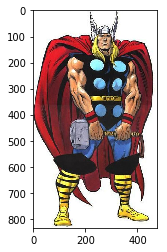

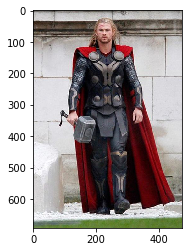

In [43]:
#display images
for img in imgs:
    imshow(img)
    show()

## Choose the proper layers and weights

In [44]:
#define layers, loss functions, weights and compute optimization targets
#The style layers can be choosen from:  style_layers = ['r11','r21','r31','r41', 'r51']
style_layers = ['r11','r21','r31']
content_layers = ['r22']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)

if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#weights for each layers can be choosen from: style_weights = [1e5/n**2 for n in [64,128,256,512,512]]
style_weights = [1e3/n**2 for n in [64,128,256]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

## Run style transfer

Iteration: 50, loss: 51164.777344
['r11: 4552.85400390625', 'r21: 10819.734375', 'r31: 13239.9296875', 'r22: 22552.259765625']
Iteration: 100, loss: 28441.841797
['r11: 620.0347290039062', 'r21: 2248.67529296875', 'r31: 4061.043701171875', 'r22: 21512.087890625']
Iteration: 150, loss: 24986.976562
['r11: 254.77468872070312', 'r21: 1425.052978515625', 'r31: 2867.91796875', 'r22: 20439.23046875']
Iteration: 200, loss: 23831.605469
['r11: 161.1839141845703', 'r21: 1178.737548828125', 'r31: 2550.63232421875', 'r22: 19941.052734375']
Iteration: 250, loss: 23345.673828
['r11: 135.60968017578125', 'r21: 1082.2265625', 'r31: 2411.884033203125', 'r22: 19715.953125']
Iteration: 300, loss: 23103.335938
['r11: 127.45405578613281', 'r21: 1035.2034912109375', 'r31: 2340.687255859375', 'r22: 19599.990234375']


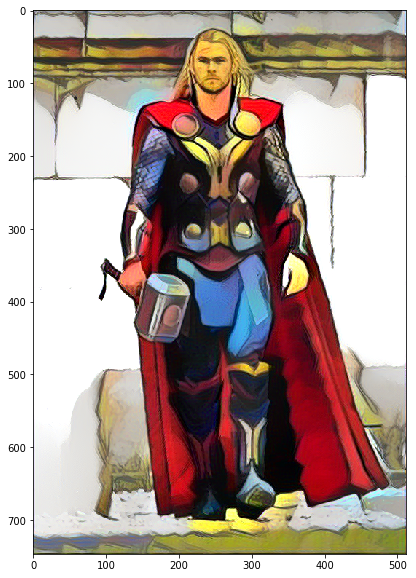

In [45]:
# Here we set max_iter = 100 in order to finish in 3 mins 
max_iter = 100
show_iter = 20
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]
loss_history = [[] for i in range(len(loss_layers)+1)]
output_dir = 'Check_point'
os.makedirs(output_dir, exist_ok=True)
checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        
def closure():
    optimizer.zero_grad()
    out = vgg(opt_img, loss_layers)
    layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
    loss = sum(layer_losses)
    loss.backward()
    n_iter[0]+=1
    loss_history[0].append(loss.item())
    for i in range(1, len(loss_history)):
        loss_history[i].append(layer_losses[i-1].item())
#    loss_history.append(loss.item())
    torch.save(out, checkpoint_path)
    #print loss
    if n_iter[0]%show_iter == (show_iter-1):
        print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
        print([loss_layers[li] + ': ' +  str(l.item()) for li,l in enumerate(layer_losses)]) #loss of each layer
    return loss

while n_iter[0] <= max_iter:
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)
string = ''
for i in range(len(style_layers)):
    string+=style_layers[i]
plt.savefig('./results/e2%s+%s.png'%(string, content_layers[0]))

## Display loss image

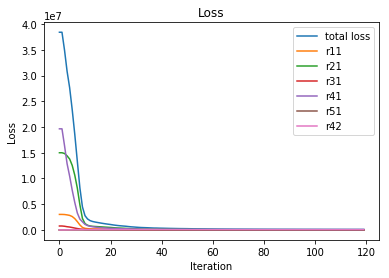

In [17]:
fig = plt.figure()
for i in range(len(loss_history)):
    plt.plot(loss_history[i])
loss_layers.insert(0,'total loss')
plt.legend(loss_layers)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('./results/loss_total.png')
plt.show()